In [2]:
%matplotlib inline

import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
import bz2
import os
from GeoBases import GeoBase

path_bookings = 'data/bookings.csv.bz2'
path_searches = 'data/searches.csv.bz2'
path_modifiedsearches = 'data/searches2.csv'

size_chunks = 1000000


print "Let's start the challenge! "

Let's start the challenge! 


In [211]:
# --------------------------------------------------------------------------
print "First Exercise : count the number of lines in Python for each file"

First Exercise : count the number of lines in Python for each file


In [212]:
nbLines_bkgs = 0
with bz2.BZ2File(path_bookings,'r') as fin:
    for line in fin:
        nbLines_bkgs += 1
        
print "File %s has %s lines " % (path_bookings,nbLines_bkgs)

File data/bookings.csv.bz2 has 10000011 lines 


In [213]:
nbLines_searches = 0
with bz2.BZ2File(path_searches,'r') as fin:
    for line in fin:
        nbLines_searches += 1

print "File %s has %s lines " % (path_searches,nbLines_searches)

File data/searches.csv.bz2 has 20390199 lines 


In [214]:
# --------------------------------------------------------------------------
print "Second Exercise : top 10 arrival airports in the world in 2013"

Second Exercise : top 10 arrival airports in the world in 2013


In [3]:
# loading bookings by chunks for memory reasons. We are only interested in 3 colonnes
bookingsReader = pd.read_csv(path_bookings, sep='^', compression='bz2', usecols=['arr_port','dep_port', 'pax'],
                iterator=True, chunksize=size_chunks)
bookings = pd.concat(bookingsReader, ignore_index=True)

In [4]:
best10airports = bookings.groupby('arr_port').aggregate(sum).sort_index(by='pax', ascending=False).head(10)
geo_a = GeoBase(data='airports', verbose=False)
for (arp,d) in best10airports.iterrows():
    print "%s (%s) : %.0f" % (arp.strip(), geo_a.get(arp.strip(), 'name'), d['pax'])

LHR (London Heathrow Airport) : 88809
MCO (Orlando International Airport) : 70930
LAX (Los Angeles International Airport) : 70530
LAS (McCarran International Airport) : 69630
JFK (John F Kennedy International Airport) : 66270
CDG (Paris - Charles-de-Gaulle) : 64490
BKK (Suvarnabhumi) : 59460
MIA (Miami International Airport) : 58150
SFO (San Francisco International Airport) : 58000
DXB (Dubai International Airport) : 55590


In [217]:
# --------------------------------------------------------------------------
print "Third Exercise : Monthly Number of searches for flights arriving at Málaga, Madrid or Barcelona"

Third Exercise : Monthly Number of searches for flights arriving at Málaga, Madrid or Barcelona


In [218]:
# Gets airport codes
malaga_airport = geo_a.fuzzyFind('Malaga','name')[0][1]
madrid_airport = geo_a.fuzzyFind('Madrid','name')[0][1]
barcelona_airport = geo_a.fuzzyFind('Barcelona','name')[0][1]
print "Malaga airport code --> %s " % (malaga_airport)
print "Madrid airport code --> %s " % (madrid_airport)
print "Barcelona airport code --> %s " % (barcelona_airport)

Malaga airport code --> AGP 
Madrid airport code --> MAD 
Barcelona airport code --> BCN 


In [219]:
searchesReader = pd.read_csv(path_searches, sep='^', compression='bz2', usecols=['Origin','Destination', 'Date'],
                iterator=True, chunksize=size_chunks)
searches_spain = pd.concat([chunk[chunk['Destination'].isin([malaga_airport,madrid_airport,barcelona_airport])] 
                            for chunk in searchesReader])

searches_spain.loc[:,'Month'] = searches_spain['Date'].map(lambda x: pd.datetime.strptime(x.strip(), '%Y-%m-%d').month)
print "Number of searches for flights arriving at Málaga, Madrid or Barcelona is %s" % len(searches_spain)

Number of searches for flights arriving at Málaga, Madrid or Barcelona is 676382


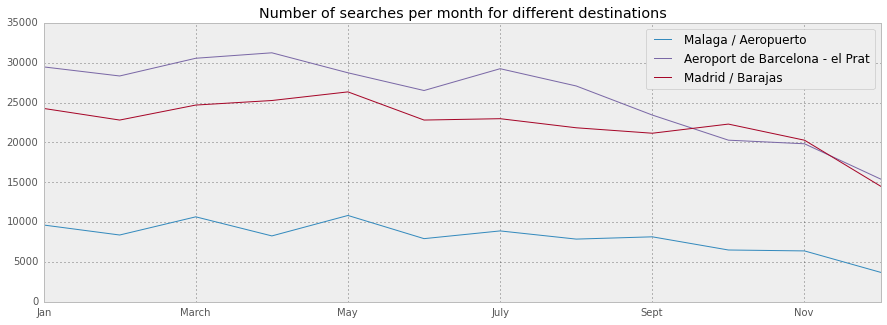

In [220]:
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots()
for arp, df in searches_spain.groupby('Destination'):
    monthlySearches = df.groupby('Month').size()
    monthlySearches.index = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'Sept', 'Oct', 'Nov', 'Dec']
    monthlySearches.plot(kind="line", x='Month', legend='Number of searches', ax=ax, label=geo_a.get(arp, 'name'), 
                         title='Number of searches per month for different destinations' )
plt.legend()

In [221]:
# --------------------------------------------------------------------------
print "Fourth (Bonus) Exercise : match searches with bookings"

Fourth (Bonus) Exercise : match searches with bookings


In [5]:
# Stores uniques airport airport for later join
airportairport = bookings.drop_duplicates(subset=['arr_port','dep_port'])
airportairport = airportairport.drop('pax',axis=1)
airportairport['arr_port'] = airportairport['arr_port'].map(str.strip)
airportairport['dep_port'] = airportairport['dep_port'].map(str.strip)
airportairport = airportairport.rename(columns={'arr_port': 'Destination', 'dep_port': 'Origin'})
airportairport.loc[:,'BookingIndicator']='1'
print 'Found %s different airport airports' % len(airportairport)

Found 78846 different airport airports


In [11]:
# Delete file in case it exists as we are appending to it
if os.path.exists(path_modifiedsearches):
    os.remove(path_modifiedsearches)

size_chunks = 1000000
    
for i in range(0, 20390199, size_chunks):
    print i
    df = pd.read_csv(path_searches, sep='^', compression='bz2', 
            header=None,  # no header, define column header manually later
            nrows=size_chunks, # number of rows to read at each iteration
            skiprows=1 if i == 0 else i)   # skip rows that were already read. skip header if first
    df.columns = header
    
    joined = pd.merge(df, airportairport,
                      on=['Origin','Destination'], 
                      how='left')
    joined['BookingIndicator'] = joined['BookingIndicator'].astype(object).fillna('0')
    joined.to_csv(path_modifiedsearches, sep='^', mode='a', header=True if i == 0 else False, index=False) 
    # header = true if first chunk

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000


In [12]:
# compression.
from shutil import copyfileobj

with open(path_modifiedsearches, 'rb') as input:
    with bz2.BZ2File(path_modifiedsearches+'.bz2', 'wb', compresslevel=9) as output:
        copyfileobj(input, output)